### import函式

In [6]:
import urllib.request #用於下載網站
import os
import numpy as np
import pandas as pd

### 下載檔案與確認資料

In [7]:
#下載Taianic_xls
url = "http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls"
file = "titanic3.xls"
urllib.request.urlretrieve(url,file)

('titanic3.xls', <http.client.HTTPMessage at 0x1198988d0>)

In [47]:
#用dataframe的方式讀取titanic3.xls
data = pd.read_excel("titanic3.xls")
# data[:2]

In [48]:
#查看欄位
#pclass艙等(1,2,3),embarked登船港口(C = Cherbourg, Q = Queenstown, S =Southampton)
#sibs手足或配偶也在船上的數量,parch雙親或子女也在船上的數量
#ticket車票號碼,cabin艙位號碼
col = data.columns
size = data.shape
print(col)
print(size)

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')
(1309, 14)


In [83]:
#將ticket,cabin,bost,body與home.dest剔除(因對生存結果毫無影響)
cols = [ 'survived', 'name','pclass', 'sex', 'age', 'sibsp', 'parch',
       'fare', 'embarked']
data = data[cols]
# data[:2]

### pandas資料預處理

In [84]:
#因要跑深度學習需要欄位必須都是數字(須對以下欄位做處理)
#name暫時去掉(做預測時在拿回)
draft = data.drop(['name'], axis=1)
# draft

In [85]:
#age與fare有部分是null,須剔除並改平均值
draft.isnull().sum() #找出null

survived      0
pclass        0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

In [86]:
age_avg = draft['age'].mean() #找出age的平均
print(age_avg)
draft['age'] = draft['age'].fillna(age_avg) #將null補上age_avg
fare_avg = draft['fare'].mean() #找出fare的平均
print(fare_avg)
draft['fare'] = draft['fare'].fillna(fare_avg) #將null補上age_avg
# draft[:2]

29.8811345124283
33.29547928134572


In [87]:
#sex(female,male)需改為0或1
draft['sex'] = draft['sex'].map({'female':0, 'male':1}).astype(int)
draft[:2]

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,1,1,0,29.0000,0,0,211.3375,S
1,1,1,1,0.9167,1,2,151.5500,S


In [88]:
#embarked改為3個港口的新欄位,並以0,1做為判斷
#get_dummies()函式運用
new_data = pd.get_dummies(data=draft,columns=['embarked'])

### Dataframe轉為Array

In [89]:
#為了讓Keras有深度學習的訓練需將DataFrame轉為Array
New_data = new_data.values

In [90]:
#先講label(survived的結果)與features(所有的特徵)分開
Label = New_data[:,0] #[全部的值,第一個欄位]
Features = New_data[:,1:] #[全部的值,除了第一個以外的值]

In [91]:
Features[:2]

array([[  1.    ,   0.    ,  29.    ,   0.    ,   0.    , 211.3375,
          0.    ,   0.    ,   1.    ],
       [  1.    ,   1.    ,   0.9167,   1.    ,   2.    , 151.55  ,
          0.    ,   0.    ,   1.    ]])

### 將欄位標準化

In [93]:
#追求預測的結果準確需將資料所有的標準化
#例：age的區間為3~70歲而 ticket則是10.~215.元無法統一比較
#故將所有數值統一在0~1區間,可提高訓練模型的準確率
from sklearn import preprocessing
#引入preprocessing.MinMaxScaler套件讓標準化後的數值在0到1之間
scale = preprocessing.MinMaxScaler(feature_range=(0,1))
Scaled_Features = scale.fit_transform(Features)
Scaled_Features[:2]

array([[0.        , 0.        , 0.36116884, 0.        , 0.        ,
        0.41250333, 0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.00939458, 0.125     , 0.22222222,
        0.2958059 , 0.        , 0.        , 1.        ]])

### 切分資料

In [96]:
#切分為預測資料30% 與訓練資料70%
split = np.random.rand(len(data)) < 0.7
train = data[split]
test = data[~split] #反向
print('total:',len(data))
print('train:',len(train))
print('test:',len(test))

total: 1309
train: 926
test: 383


In [97]:
#將所有資料處理包成fun後直接將切分好的資料帶入
def PreprocessData(data):
    draft = data.drop(['name'], axis=1)
    age_avg = draft['age'].mean()
    draft['age'] = draft['age'].fillna(age_avg)
    fare_avg = draft['fare'].mean()
    draft['fare'] = draft['fare'].fillna(fare_avg)
    draft['sex'] = draft['sex'].map({'female':0, 'male':1}).astype(int)
    new_data = pd.get_dummies(data=draft,columns=['embarked'])
    
    New_data = new_data.values
    Label = New_data[:,0]
    Features = New_data[:,1:]
    
    scale = preprocessing.MinMaxScaler(feature_range=(0,1))
    Scaled_Features = scale.fit_transform(Features)
    
    return Scaled_Features,Label

In [100]:
#將資料放入
#若無特別指定,第一個的變數為return的第一個值以此類推
train_Feature,train_Label = PreprocessData(train)
test_Feature,test_Label = PreprocessData(test)

### 匯入Keras預測模組


In [101]:
from keras.models import Sequential
from keras.layers import Dense,Dropout

In [107]:
#建立 keras Sequential模型
model = Sequential()

### Keras多層感知器(MLP)類神經傳導

In [108]:
#第一層
#共有9個features故input_dim為9個神經元(輸入)
#units=40個神經元(輸出)
#使用uniform distribution分布的亂數初始化權重(weight)與偏差值(bias)
#激活(activation)函數relu
model.add(Dense(units=40, input_dim=9,
                kernel_initializer='uniform',
                activation='relu'))

In [109]:
#第二層
#units=1個神經元(輸出)
#使用uniform distribution分布的亂數初始化權重(weight)與偏差值(bias)
#激活(activation)函數sigmoid
model.add(Dense(units=1,
                kernel_initializer='uniform',
                activation='sigmoid'))


In [110]:
#定義訓練方式compile
#設定損失函數(loss function)深度學習中cross_entropy訓練效果較好
#設定最優化方法(optimizer)深度學習中adam可提高準確率
#設定評估模型的方式是accuracy
model.compile(loss = 'binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

### 開始訓練

In [111]:
#validation_split=0.1會切分成90%訓練資料10%驗證資料(內部)
#epochs=30執行30次訓練週期,batch_size=30每一批次30筆資料
#verbose=2會顯示2次的訓練過程
train_history = model.fit(x=train_Feature,
                          y=train_Label,
                          validation_split=0.1,
                          epochs=30,
                          batch_size=30,verbose=2)

Epoch 1/30
28/28 - 0s - loss: 0.6860 - accuracy: 0.6086 - val_loss: 0.6635 - val_accuracy: 0.7634
Epoch 2/30
28/28 - 0s - loss: 0.6653 - accuracy: 0.6122 - val_loss: 0.6155 - val_accuracy: 0.7634
Epoch 3/30
28/28 - 0s - loss: 0.6367 - accuracy: 0.6206 - val_loss: 0.5623 - val_accuracy: 0.7634
Epoch 4/30
28/28 - 0s - loss: 0.6074 - accuracy: 0.6591 - val_loss: 0.5220 - val_accuracy: 0.7634
Epoch 5/30
28/28 - 0s - loss: 0.5791 - accuracy: 0.6915 - val_loss: 0.5035 - val_accuracy: 0.7849
Epoch 6/30
28/28 - 0s - loss: 0.5549 - accuracy: 0.7383 - val_loss: 0.4831 - val_accuracy: 0.7742
Epoch 7/30
28/28 - 0s - loss: 0.5319 - accuracy: 0.7731 - val_loss: 0.4791 - val_accuracy: 0.7742
Epoch 8/30
28/28 - 0s - loss: 0.5163 - accuracy: 0.7827 - val_loss: 0.4656 - val_accuracy: 0.7742
Epoch 9/30
28/28 - 0s - loss: 0.5049 - accuracy: 0.7827 - val_loss: 0.4581 - val_accuracy: 0.7527
Epoch 10/30
28/28 - 0s - loss: 0.4972 - accuracy: 0.7755 - val_loss: 0.4547 - val_accuracy: 0.8065
Epoch 11/30
28/28 -

### 以圖表顯示測試結果

In [113]:
#設定函示
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.xlabel('訓練週期')
    plt.ylabel(train)
    plt.legend([train,validation], loc='upper left')
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 35347 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 32244 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 36913 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26399 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 35347 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 32244 missing from cur

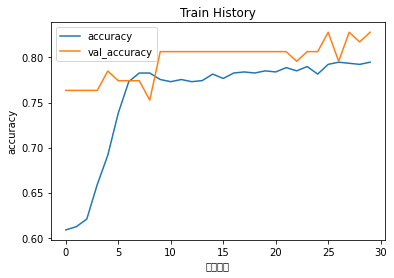

In [116]:
#套入準確性數值,可以看出準確率越來越高
#loss: 0.6860 - accuracy: 0.6086 - val_loss: 0.6635 - val_accuracy: 0.7634
show_train_history(train_history,'accuracy','val_accuracy')

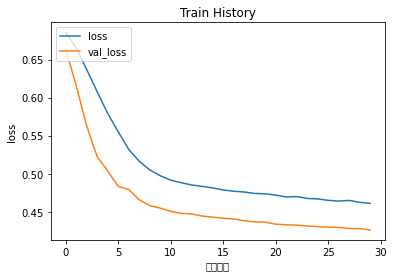

In [117]:
#套入誤差性數值,可以看出誤差性越來越低
show_train_history(train_history,'loss','val_loss')

### 評估模型準確率

In [120]:
#用測試的資料(test)評估準確性
scores = model.evaluate(x=test_Feature,
                         y=test_Label)
scores[1]

12/12 [==============================] - 0s 2ms/step - loss: 0.4519 - accuracy: 0.8016


0.8015666007995605

### 加入jack跟rose的資料測試

In [121]:
Jack = pd.Series([0,'Jack',3, 'male'  , 23, 1, 0,   5.0000,'S'])
Rose = pd.Series([1,'Rose',1, 'female', 20, 1, 0, 100.0000,'S'])


In [122]:
#轉成dataframe
JR_data = pd.DataFrame([list(Jack),list(Rose)],
                       columns=['survived', 'name','pclass', 'sex',
                                'age', 'sibsp', 'parch','fare', 'embarked'])

In [123]:
#將原先資料加上Jack跟Rose的資料
data=pd.concat([data,JR_data])
data[-2:]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
0,0,Jack,3,male,23.0,1,0,5.0,S
1,1,Rose,1,female,20.0,1,0,100.0,S


In [124]:
#開始預測
#將新資料放入PreprocessData函式中
new_Feature,Label = PreprocessData(data)

In [125]:
#用model.predict直接預測
#觀看前10筆的旅客生存機率
all_probability = model.predict(new_Feature)
all_probability[:10]

array([[0.94834906],
       [0.45161515],
       [0.924723  ],
       [0.3556095 ],
       [0.9200696 ],
       [0.26594734],
       [0.8671639 ],
       [0.2765067 ],
       [0.8386313 ],
       [0.3402276 ]], dtype=float32)

In [126]:
#將預測結果(probability)加入data之中即可直接對照該旅客的生存機率
data.insert(len(data.columns),
           'probability',all_probability)
data[-2:] #最後2筆為Jack與Rose的資料

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
0,0,Jack,3,male,23.0,1,0,5.0,S,0.122350
1,1,Rose,1,female,20.0,1,0,100.0,S,0.916911
